In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
# from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sc.settings.verbosity = 3            
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

adata = sc.read_10x_mtx(
    "temp_asc_vaccines/mcm287_A",  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)
adata.var_names_make_unique()
sample = 'mcm287_A' #sample name
results_file = sample + '_sr.h5ad'  # the file that will store the analysis results
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))


adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1


sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','percent_ribo'],
             jitter=0.4, multi_panel=True)

scanpy==1.9.6 anndata==0.10.2 umap==0.5.4 numpy==1.26.4 scipy==1.11.3 pandas==2.2.2 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10
... reading from cache file cache\temp_asc_vaccines-mcm287_A-matrix.h5ad


c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(

In [3]:
initial_cell_count = adata.n_obs
print(f"Initial number of cells: {initial_cell_count}")

# sc.pp.filter_cells(adata, min_counts= 4000)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.filter_cells(adata, max_counts = 150000)

cell_count = adata.n_obs

adata = adata[adata.obs.n_genes_by_counts > 600, :]

filtered_cell_count = adata.n_obs

adata = adata[adata.obs.pct_counts_mt < 10, :]

filtered_cell_count2 = adata.n_obs

cells_filtered_out = cell_count - filtered_cell_count
cells_filtered_out2 = filtered_cell_count - filtered_cell_count2


print(f"Number of cells filtered out in counts filtering: {cells_filtered_out}")
print(f"Number of cells after counts filtering: {filtered_cell_count}")
print(f"Number of cells filtered out in mt filtering: {cells_filtered_out2}")
print(f"Number of cells after mt filtering: {filtered_cell_count2}")

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'percent_ribo'],
             jitter=0.4, multi_panel=True)

annot = sc.queries.biomart_annotations(
    "hsapiens",
    ["ensembl_gene_id", "gene_biotype"], use_cache = True
).set_index('ensembl_gene_id')
adata.var['gene_ids'] = adata.var['gene_ids'].astype(str)
annot.index = annot.index.astype(str)
gene_biotype_dict = annot['gene_biotype'].to_dict()
adata.var['gene_biotype'] = adata.var['gene_ids'].map(gene_biotype_dict)
genes_to_exclude = ['IG_C_gene', 'IG_C_pseudogene', 'IG_D_gene', 'IG_D_pseudogene', 'IG_J_gene', 'IG_LV_gene', 'IG_pseudogene', 'IG_V_gene', 'IG_V_pseudogene', 'IG_J_pseudogene']  # Replace with your list of genes
print(adata)
# Create a mask to filter out these genes
mask = ~adata.var["gene_biotype"].isin(genes_to_exclude)
# Create a new AnnData object with the filtered genes
adata_filtered = adata.copy()
adata_filtered = adata_filtered[:, mask]

########
adata.obs['IG_gene_expression'] = adata[:, ~mask].X.sum(axis=1)

adata.obs['total_gene_expression'] = adata.X.sum(axis=1)


# Calculate the percentage of IG gene expression relative to the total gene expression
adata_filtered.obs['IG_gene_percentage'] = (adata.obs['IG_gene_expression'] / adata.obs['total_gene_expression']) * 100
adata_filtered.write(sample + '_foritgr.h5ad')
########

Initial number of cells: 10528
filtered out 14634 genes that are detected in less than 3 cells
Number of cells filtered out in counts filtering: 1381
Number of cells after counts filtering: 9147
Number of cells filtered out in mt filtering: 48
Number of cells after mt filtering: 9099


c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na optio

C:\Users\Caleb\AppData\Local\Temp\ipykernel_24444\998775629.py:35: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_ids'] = adata.var['gene_ids'].astype(str)


AnnData object with n_obs × n_vars = 9099 × 21967
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'percent_ribo', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'gene_biotype'


C:\Users\Caleb\AppData\Local\Temp\ipykernel_24444\998775629.py:54: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_filtered.obs['IG_gene_percentage'] = (adata.obs['IG_gene_expression'] / adata.obs['total_gene_expression']) * 100


In [4]:
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
sc.pp.log1p(adata_filtered)
adata_filtered.raw = adata_filtered
# Find highly variable genes
#finds and plots highly variable genes
sc.pp.highly_variable_genes(adata_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)

#filters the adata to include only the highly variable genes
adata_filtered = adata_filtered[:, adata_filtered.var.highly_variable]

#regresses out the total counts and mitochondrial counts before doing principal component analysis
sc.pp.regress_out(adata_filtered, ['total_counts', 'pct_counts_mt', 'percent_ribo'])

#Scales each gene to unit variance and clips values exceeding standard deviation 10.
sc.pp.scale(adata_filtered, max_value=10)

#performs principal coponent analysis and plots the variance ratio
sc.tl.pca(adata_filtered, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_filtered, log=True)

#preserves a copy of the adata object
copydata = adata_filtered.copy()
#calls the standard dimensionality reduction and clustering steps on the adata object 
# neighbors, UMAP, and leiden (clustering)
sc.pp.neighbors(adata_filtered, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_filtered)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt', 'percent_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:01:12)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)


In [ ]:
# sc.external.pp.scrublet(adata_filtered)
# sc.external.pl.scrublet_score_distribution(adata_filtered)
# adata_filtered = (adata_filtered[adata_filtered.obs['predicted_doublet'] == False])

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


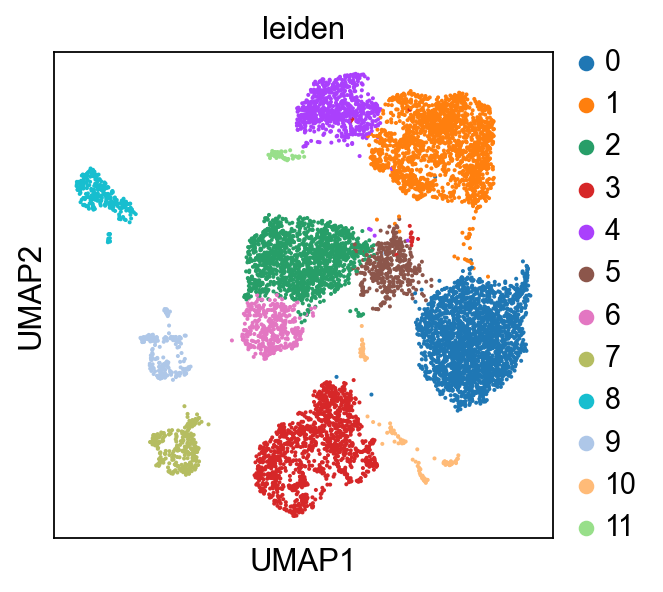

KeyError: 'Could not find key IG_gene_percentage in .var_names or .obs.columns.'

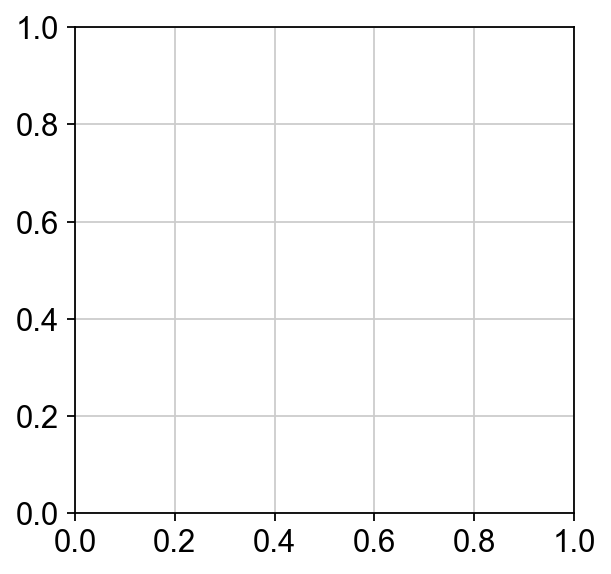

In [7]:
#clustering resolution should be adjusted to ensure that it matches the elbow plot produced above
#cut off should be around the "elbow" or corner of the plot where intra-PC variance becomes minimal
res = .3
sc.tl.leiden(adata_filtered, resolution= res, key_added = "leiden")

#plots the umap based on both sample and cluster
sc.pl.umap(adata_filtered, color = ['leiden'], hspace = 1)


adata.obsm['X_umap'] = adata_filtered.obsm['X_umap']

# Sum the expression values of the genes to exclude

# Plot UMAP and color by the combined expression
sc.pl.umap(adata, color=['IG_gene_expression'])

# Plot UMAP and color by the percentage of IG gene expression
sc.pl.umap(adata, color=['IG_gene_percentage'])

adata_filtered.obs['IG_gene_percentage'] = adata.obs['IG_gene_percentage']

# Extract leiden cluster information
leiden_clusters = adata_filtered.obs['leiden']
cluster_counts = leiden_clusters.value_counts().sort_index()

# Get UMAP colors for each cluster
umap_colors = adata_filtered.uns['leiden_colors']

reformed_counter = len(cluster_counts)
umap_colors = umap_colors[0: reformed_counter]

# Create a DataFrame for easy handling
df = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Count': cluster_counts.values,
    'Color': umap_colors
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df['Cluster'], df['Count'], color=df['Color'])

# Adding count values above the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, int(yval), ha='center', va='bottom')

# Customize plot
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')
ax.set_title('Data Count by Leiden Cluster')
ax.set_xticks(np.arange(len(df['Cluster'])))
ax.set_xticklabels(df['Cluster'])

plt.show()

In [ ]:

sc.tl.rank_genes_groups(adata_filtered, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_filtered, n_genes=20, sharey=False)
ranks = pd.DataFrame(adata_filtered.uns['rank_genes_groups']['names']).head(50)
ranks.to_csv('rank_genes_groups' + sample + '.csv')
result = adata_filtered.uns['rank_genes_groups']
groups = result['names'].dtype.names
scoresgroup = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)
scoresgroup.to_csv('scores' + sample + '.csv')
del adata_filtered.var['gene_biotype']
adata_filtered.write(results_file)


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


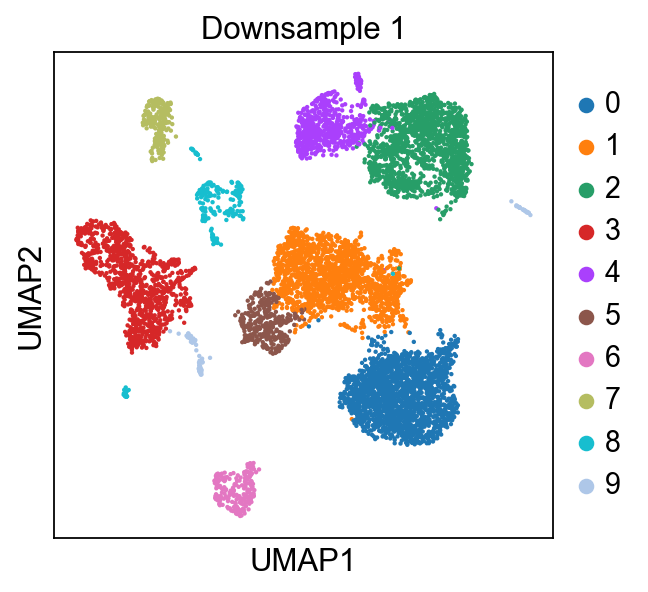

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


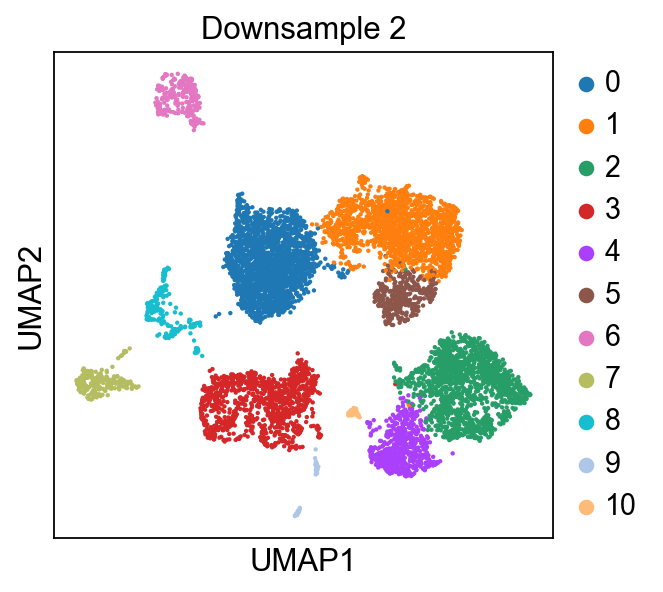

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


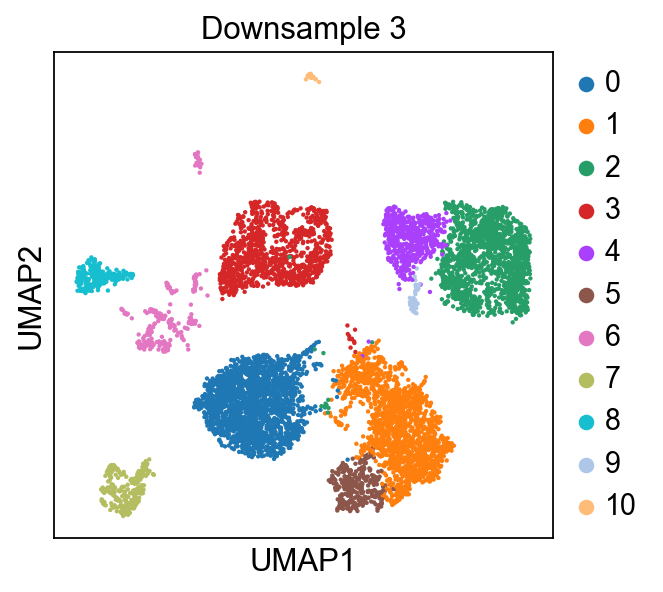

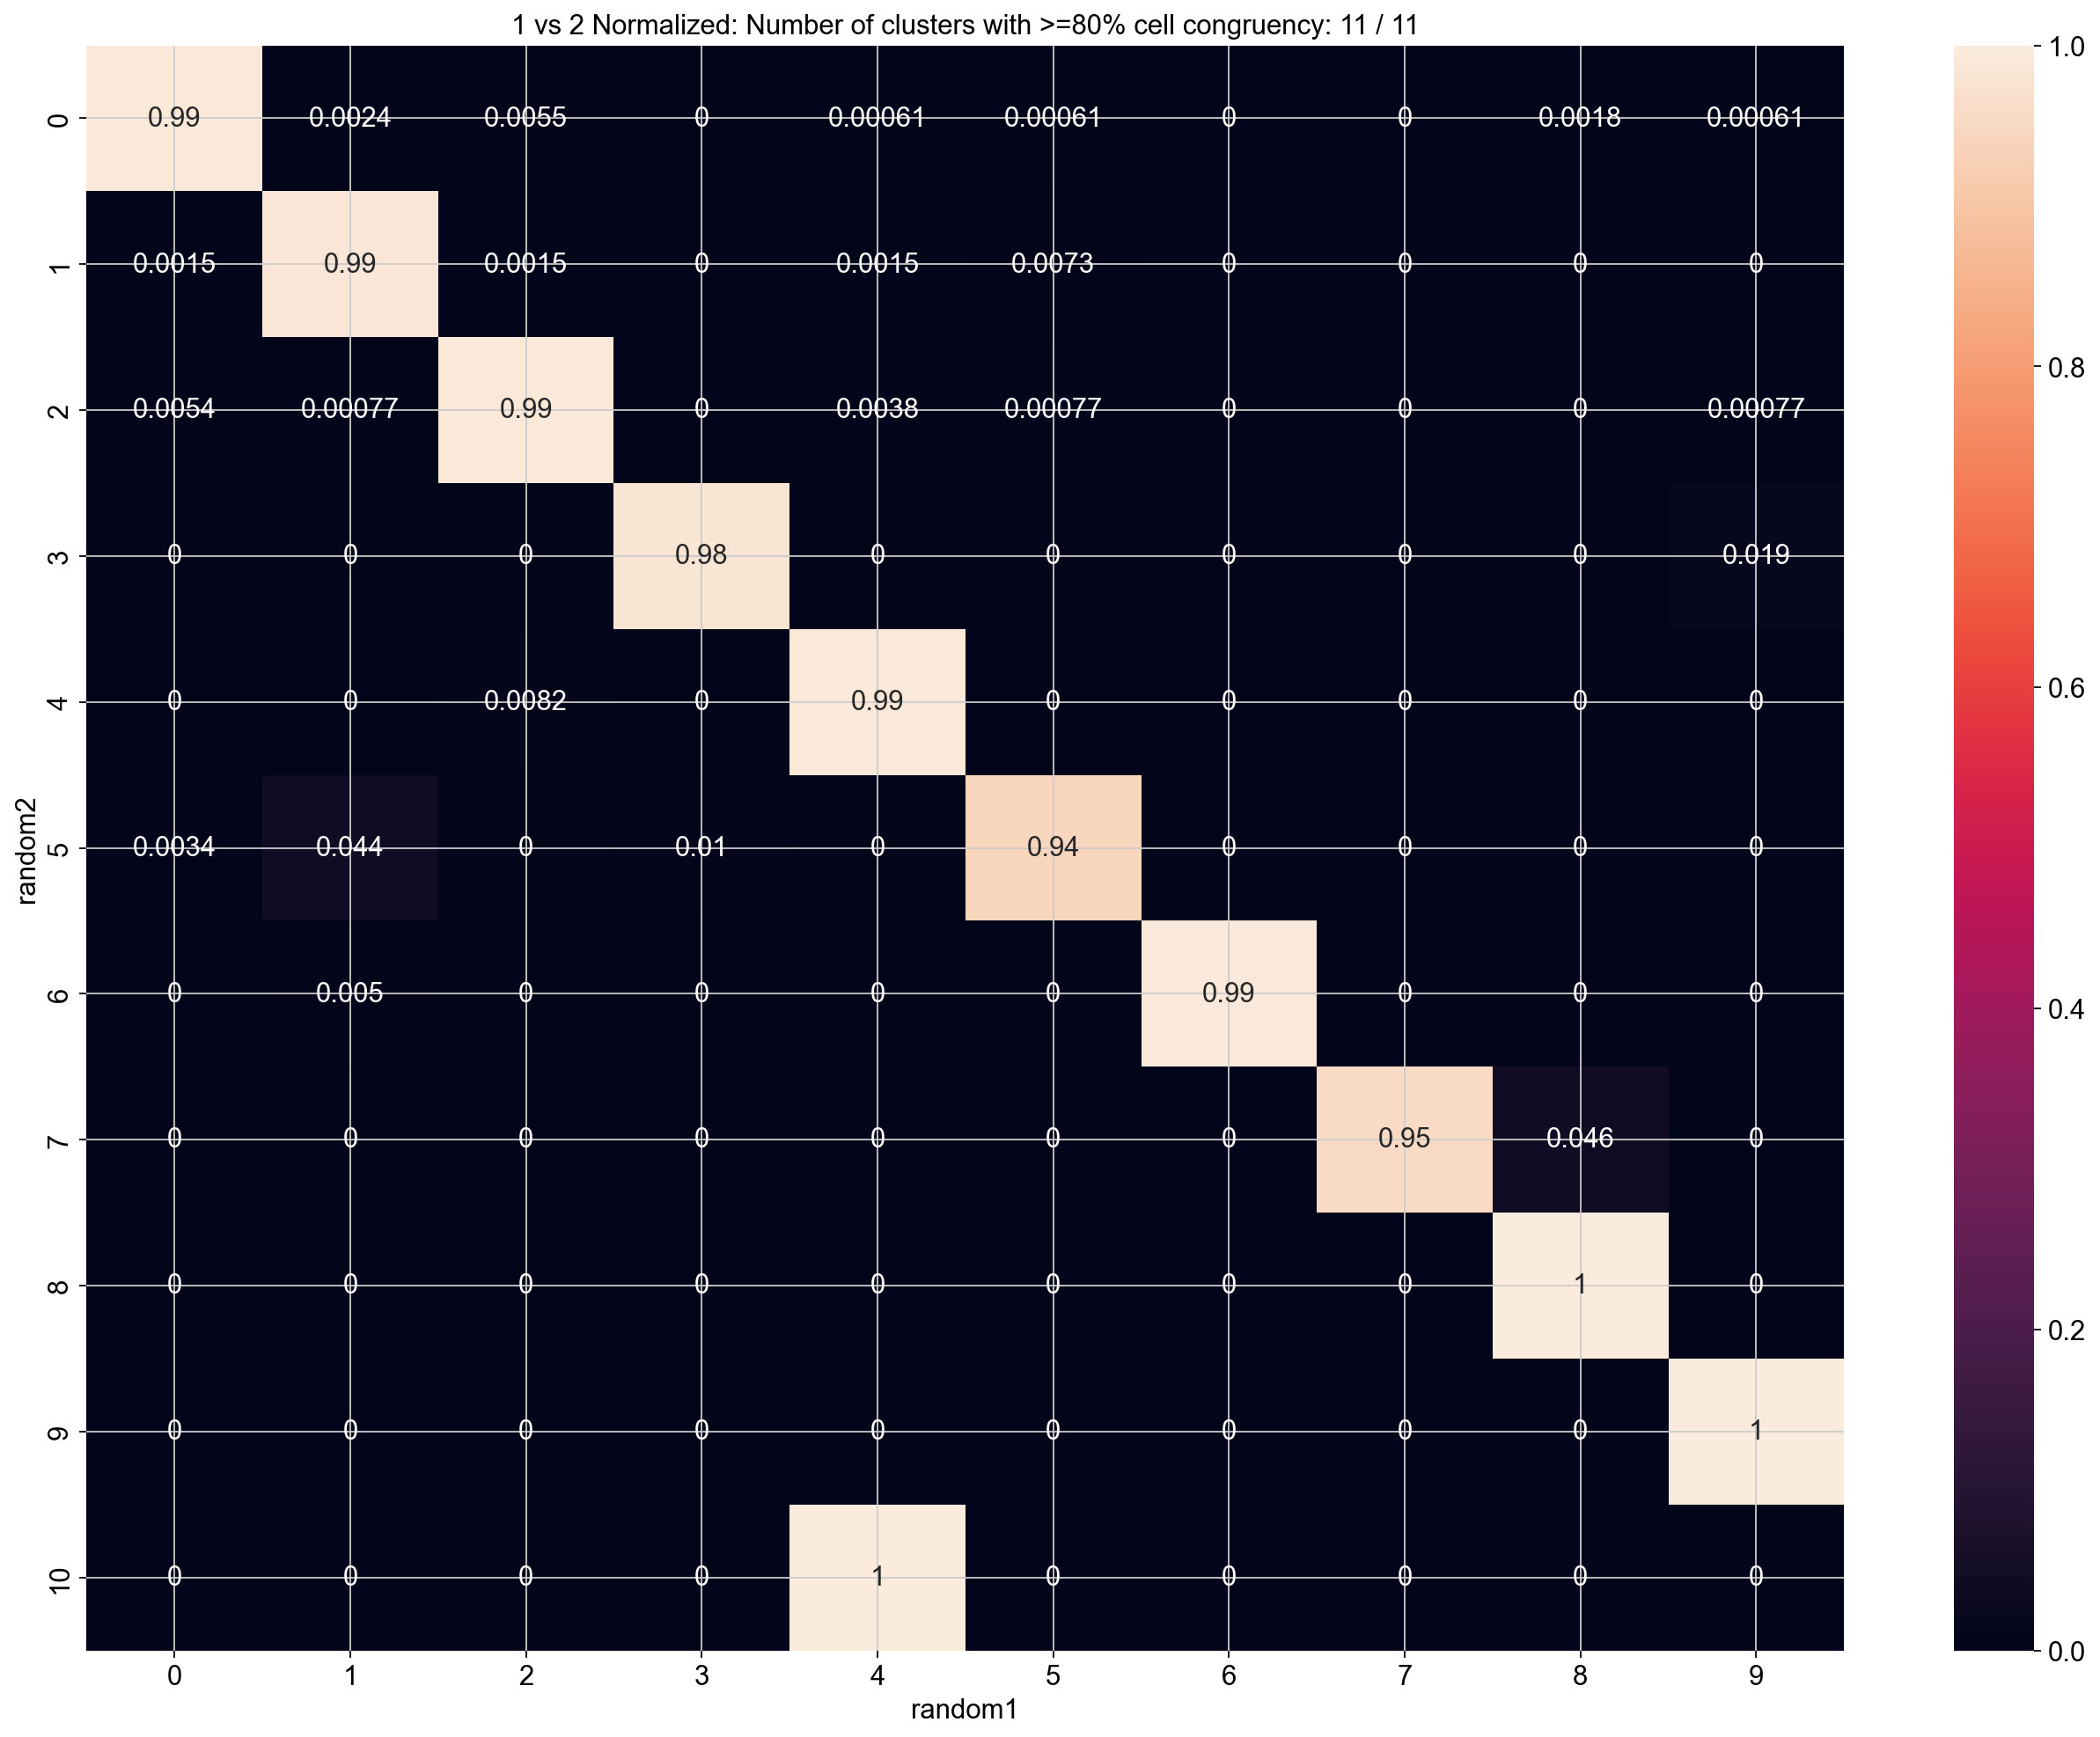

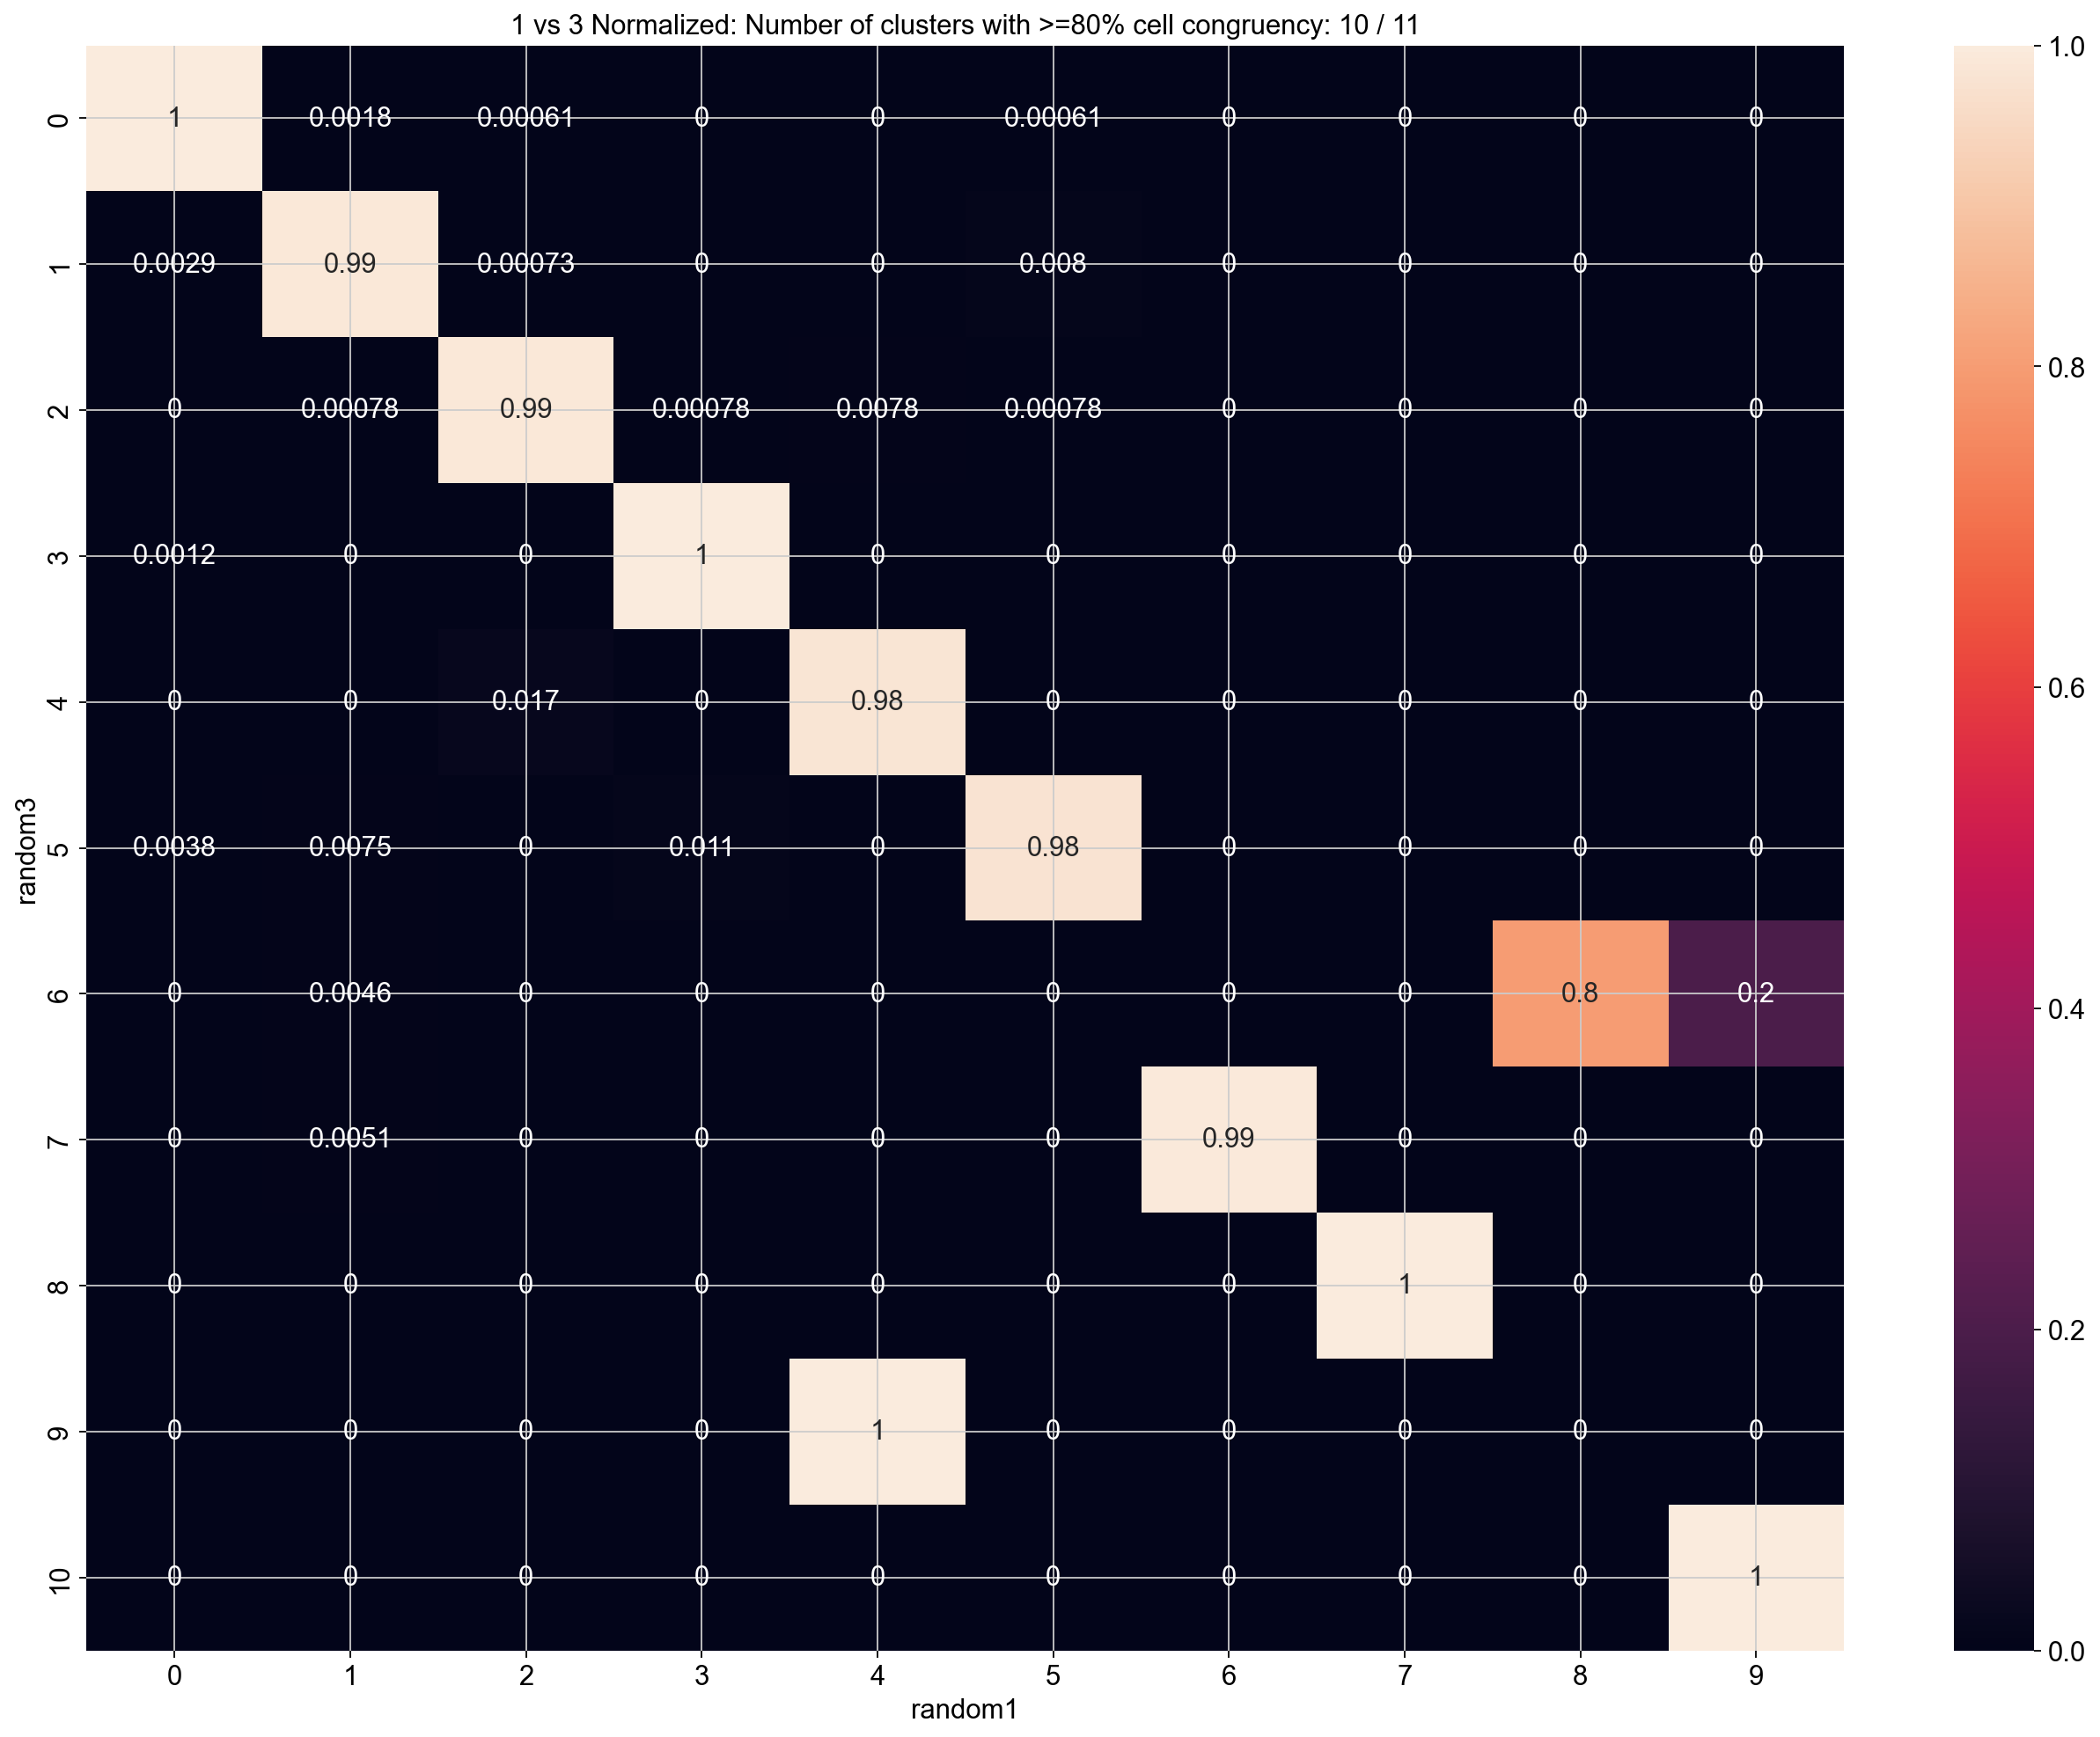

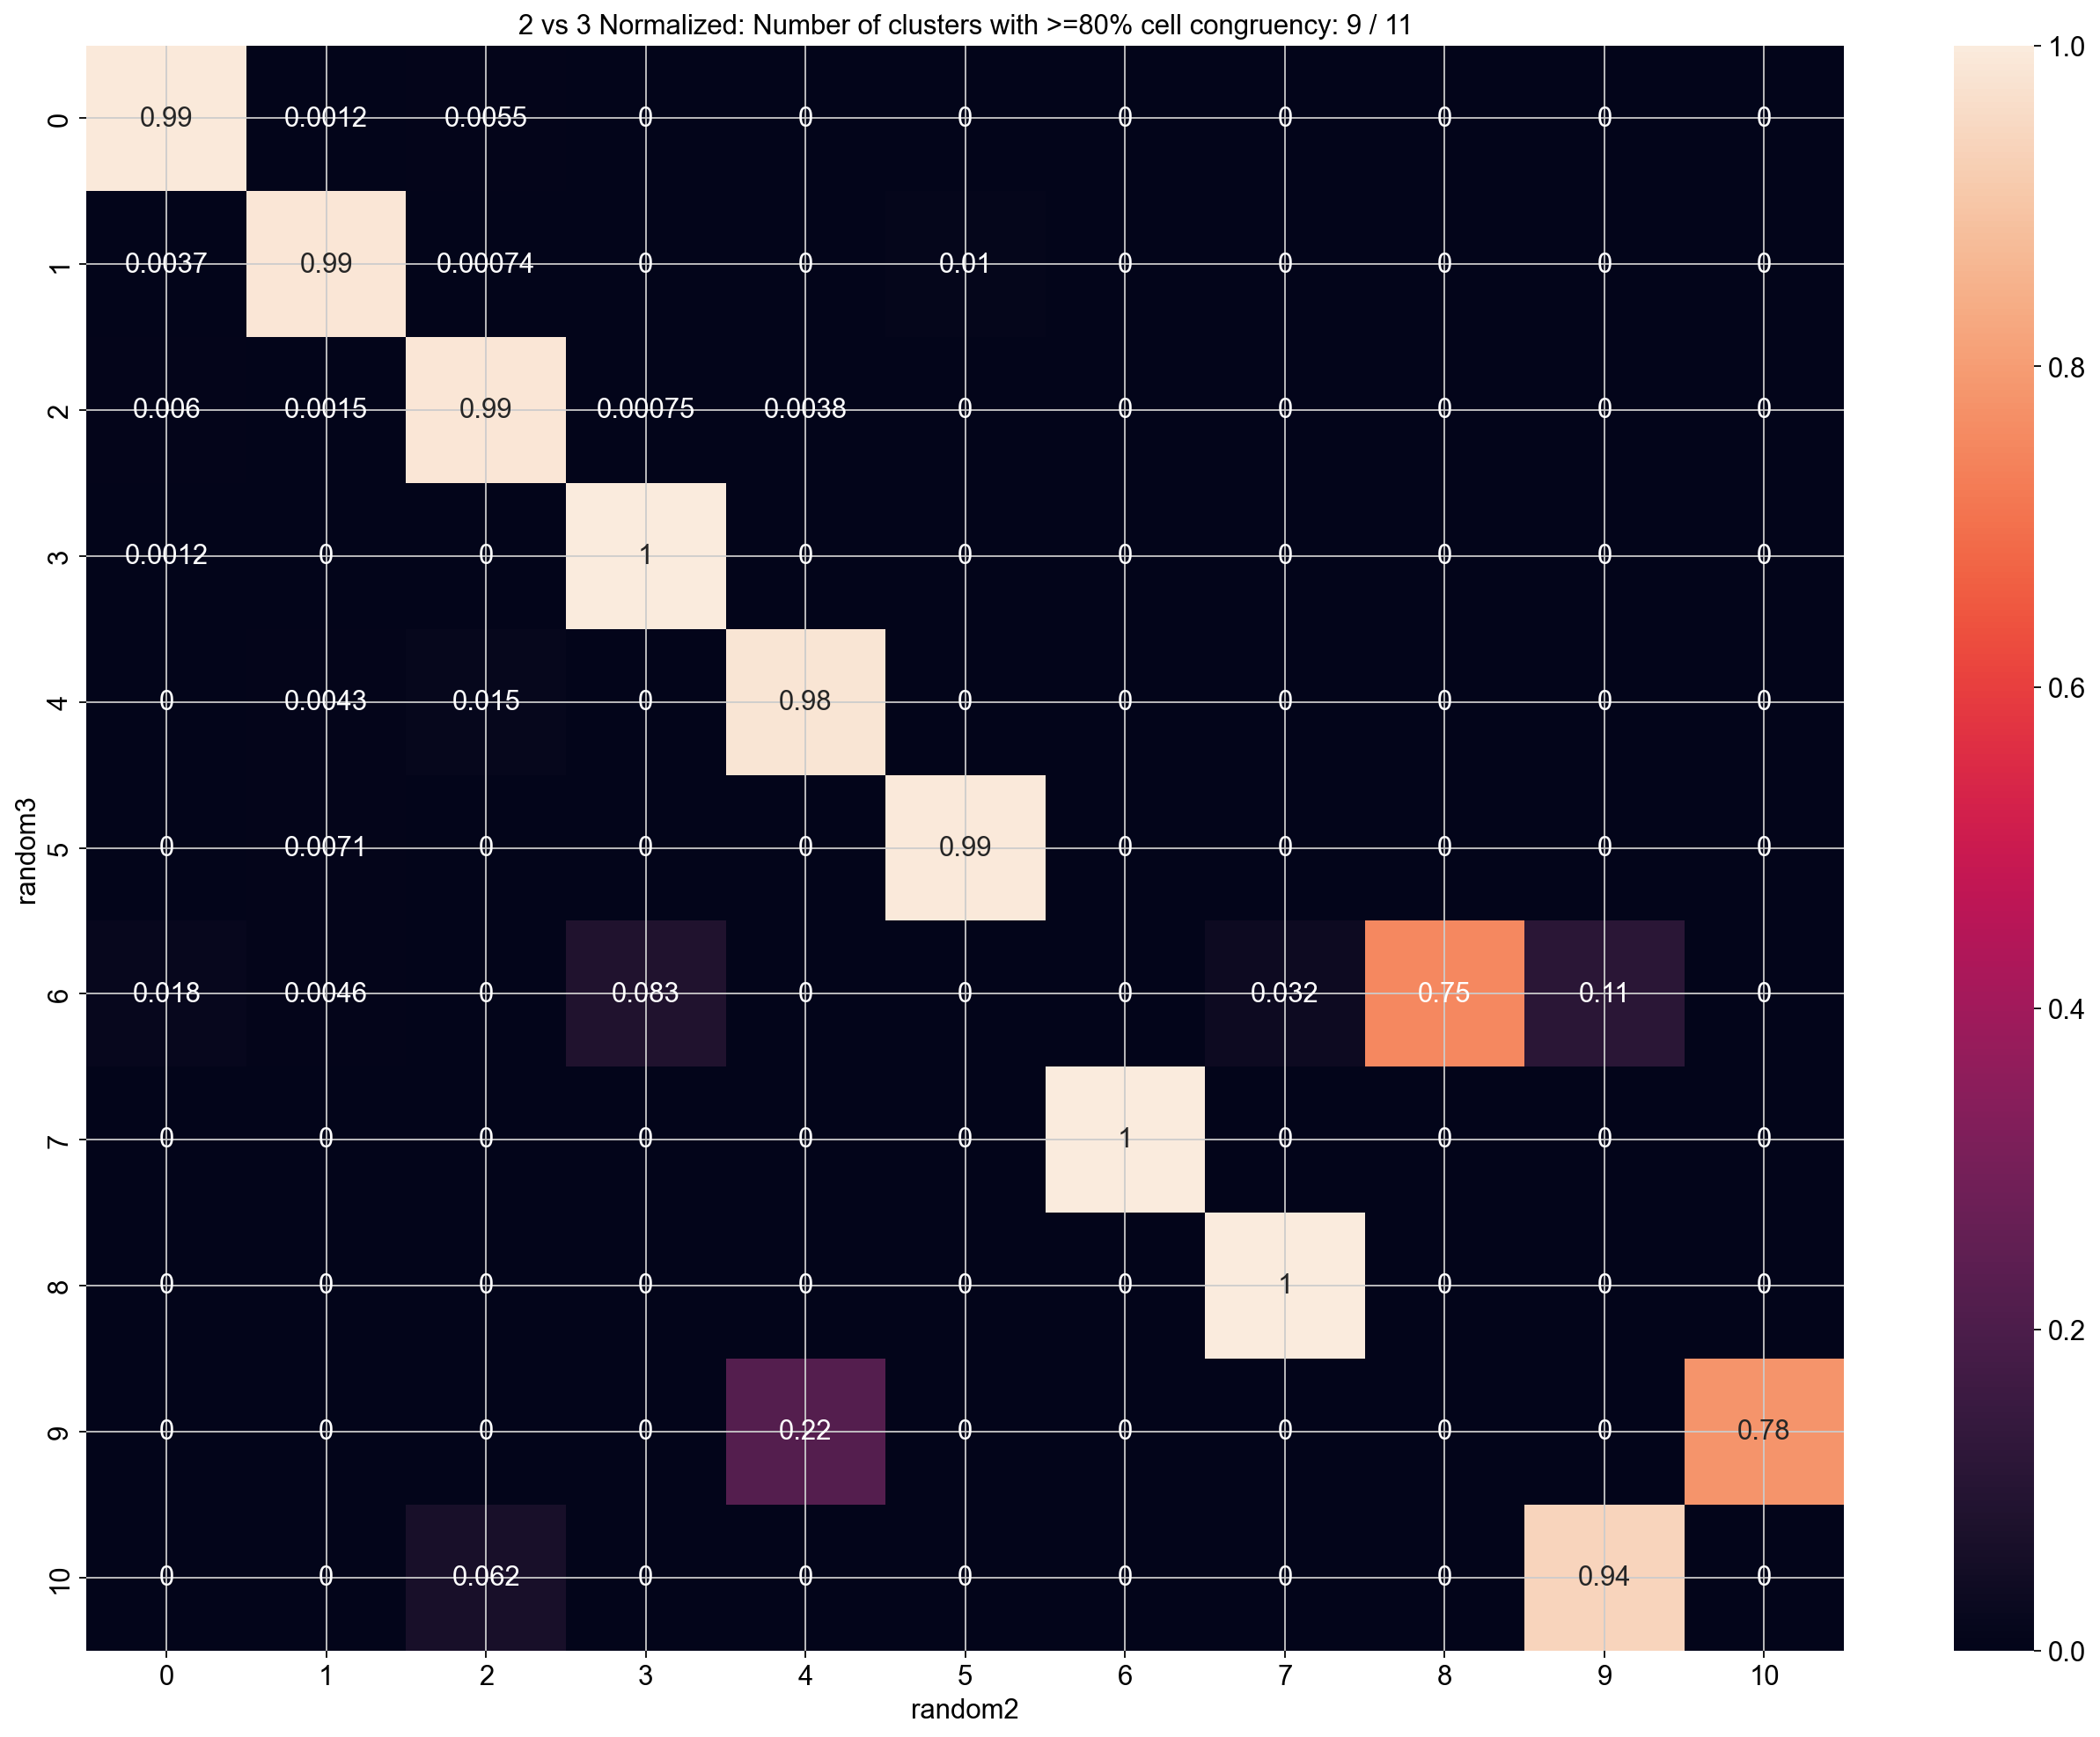

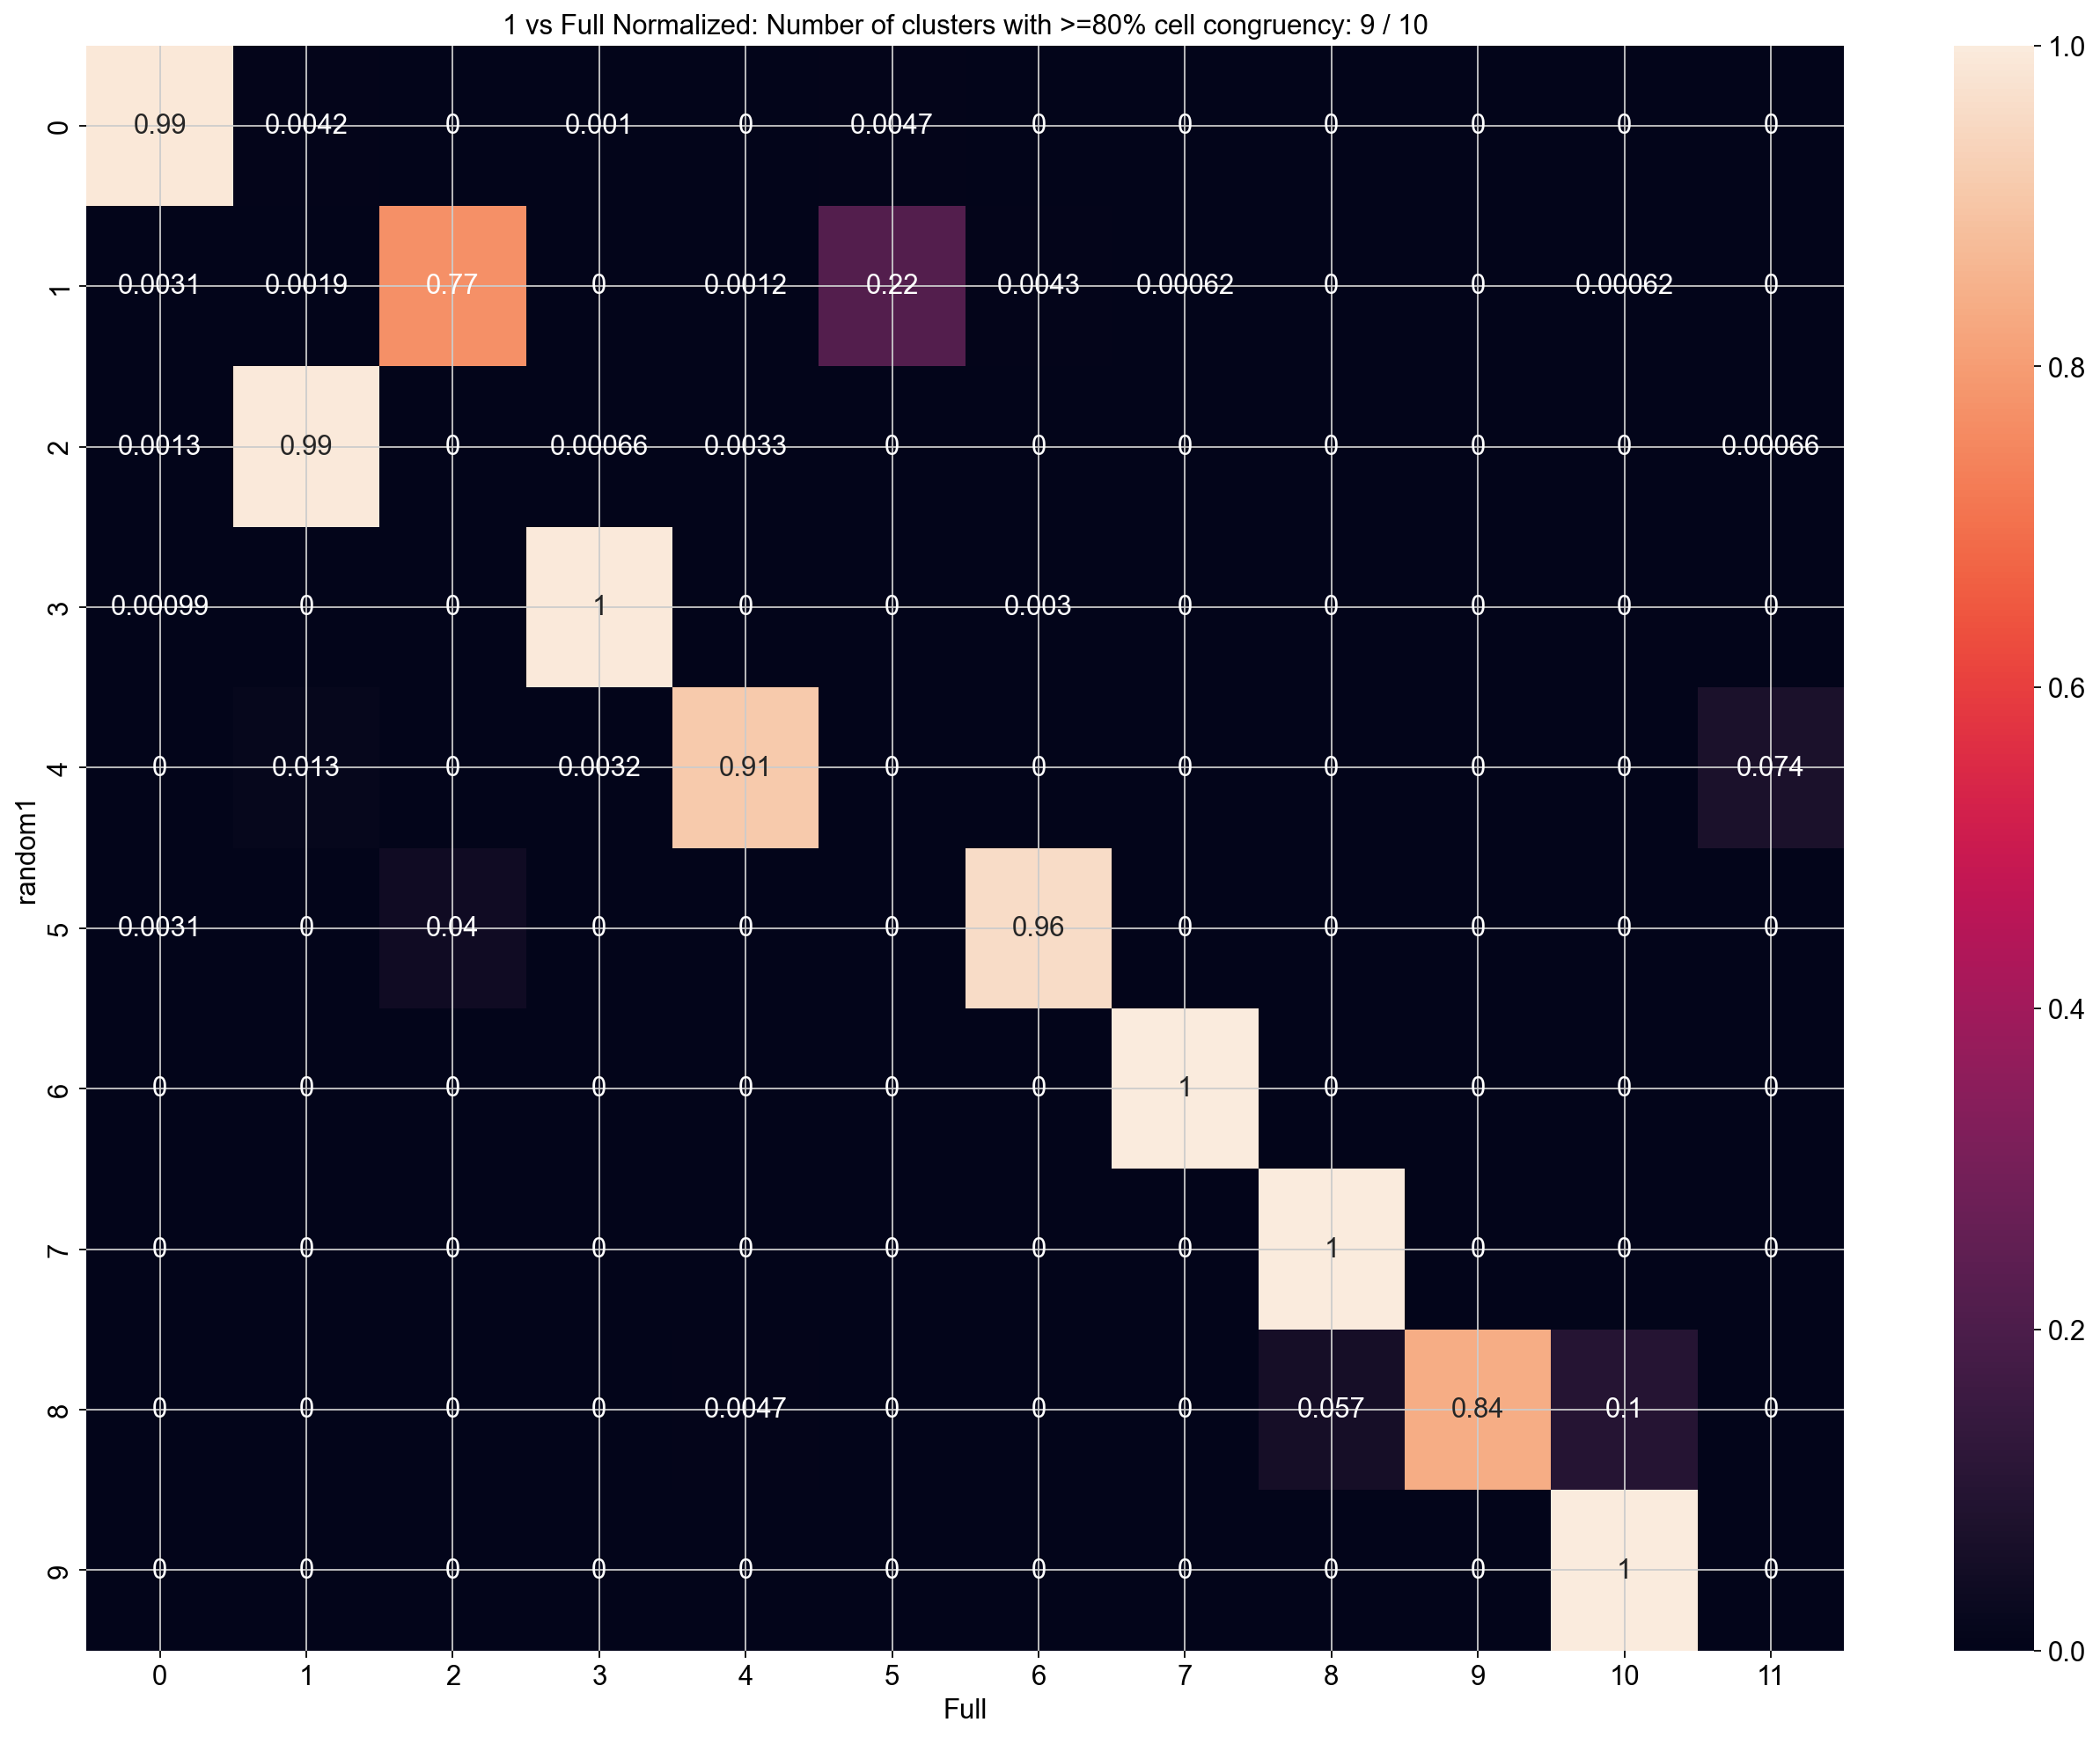

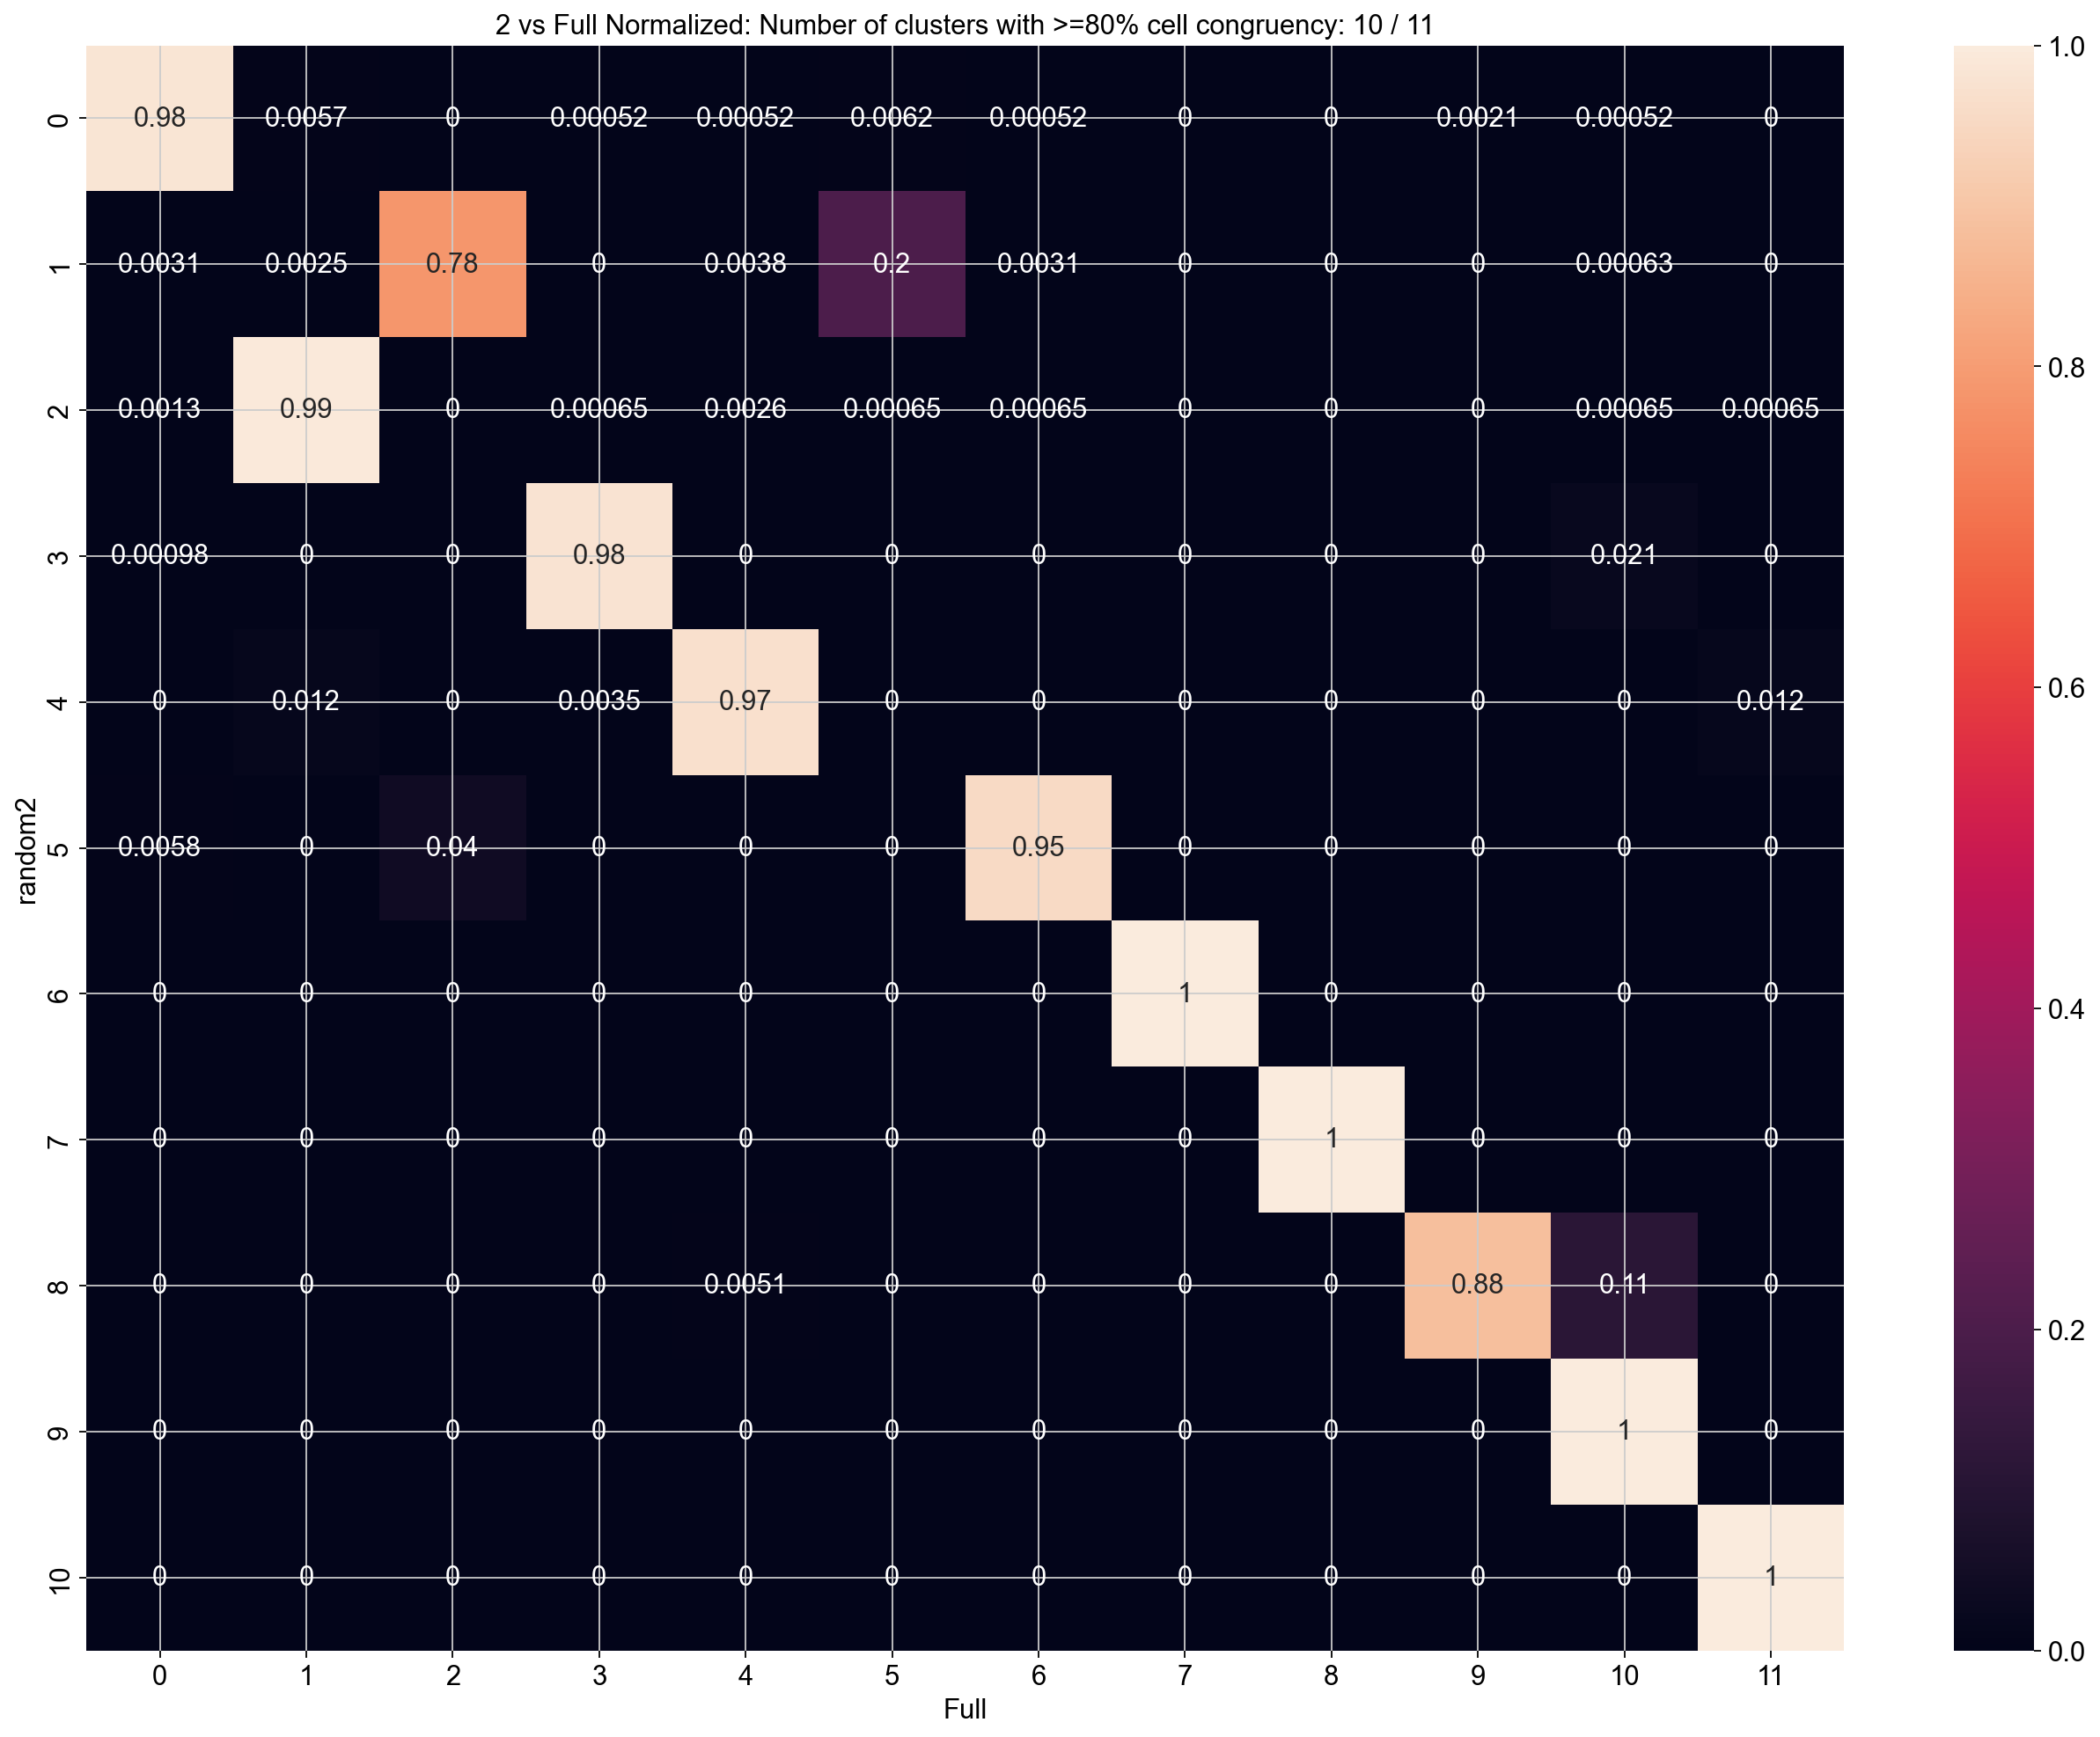

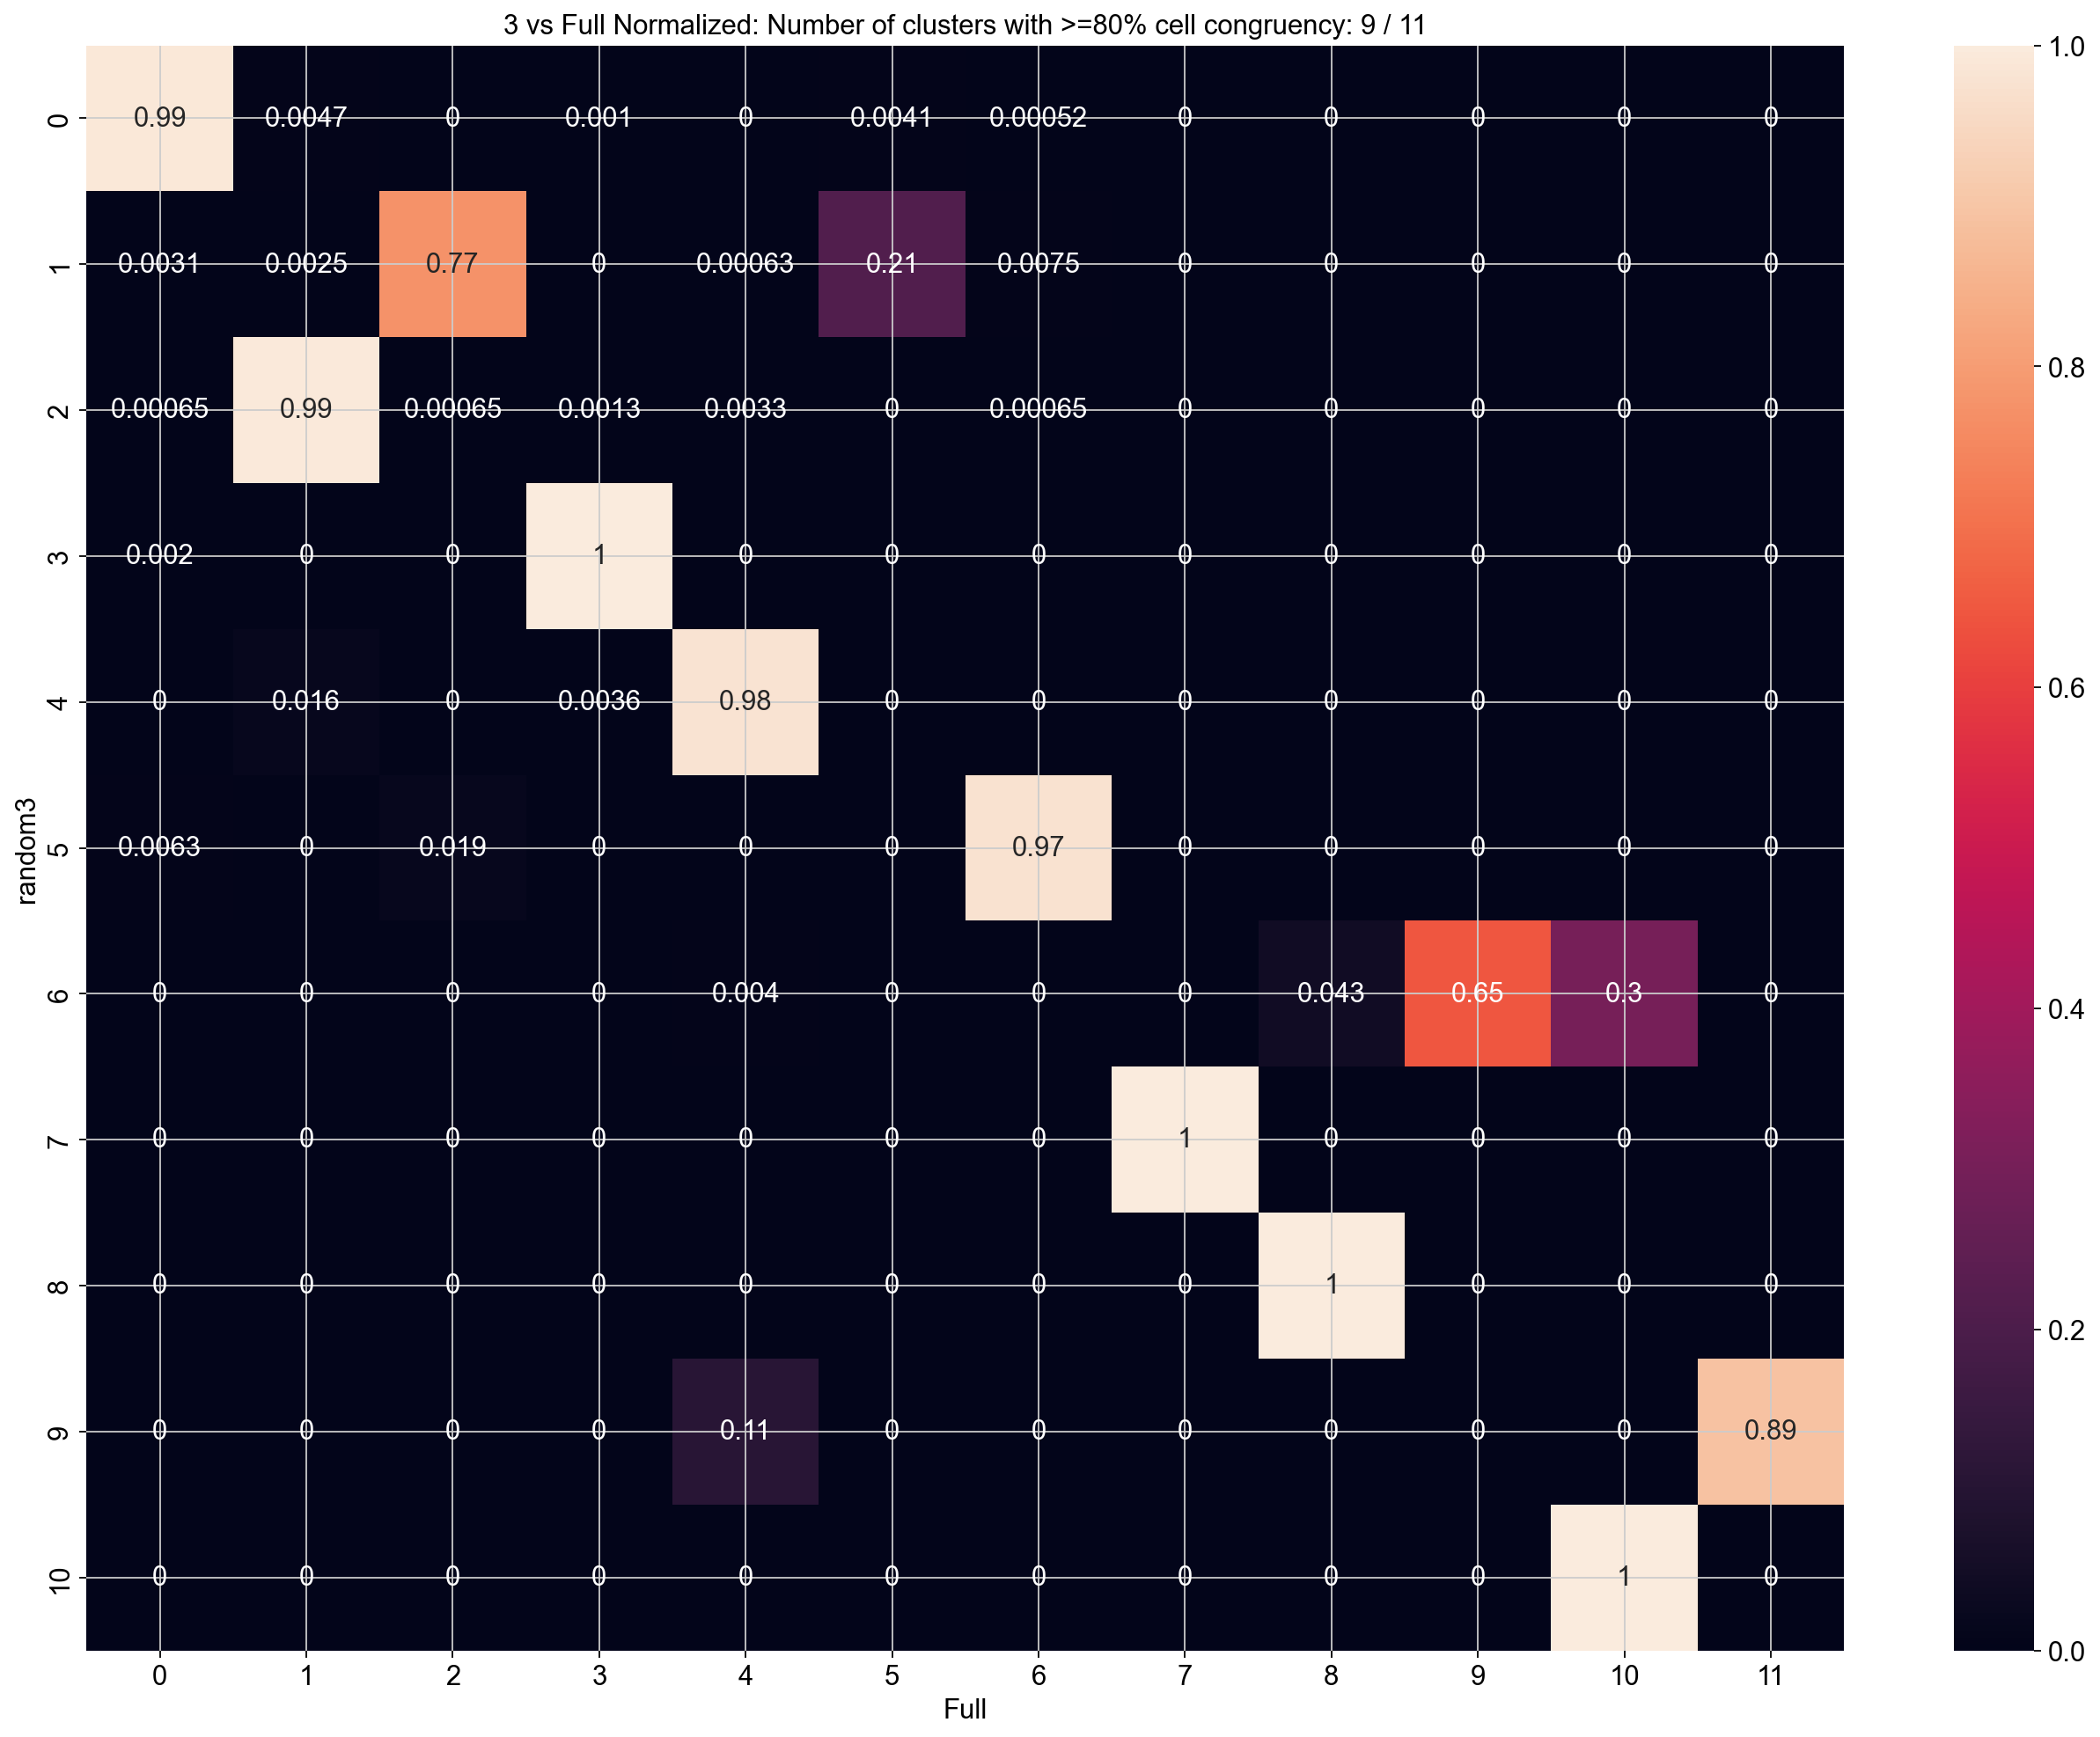

Selected Clusters and Column Values:
{'iteration0':   Row Cluster
0   0       0
1   1  [2, 5]
2   2       1
3   3       3
4   4       4
5   5       6
6   6       7
7   7       8
8   8       9
9   9      10, 'iteration1':    Row Cluster
0    0       0
1    1  [2, 5]
2   10      11
3    2       1
4    3       3
5    4       4
6    5       6
7    6       7
8    7       8
9    8       9
10   9      10, 'iteration2':    Row  Cluster
0    0        0
1    1   [2, 5]
2   10       10
3    2        1
4    3        3
5    4        4
6    5        6
7    6  [9, 10]
8    7        7
9    8        8
10   9       11}


c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


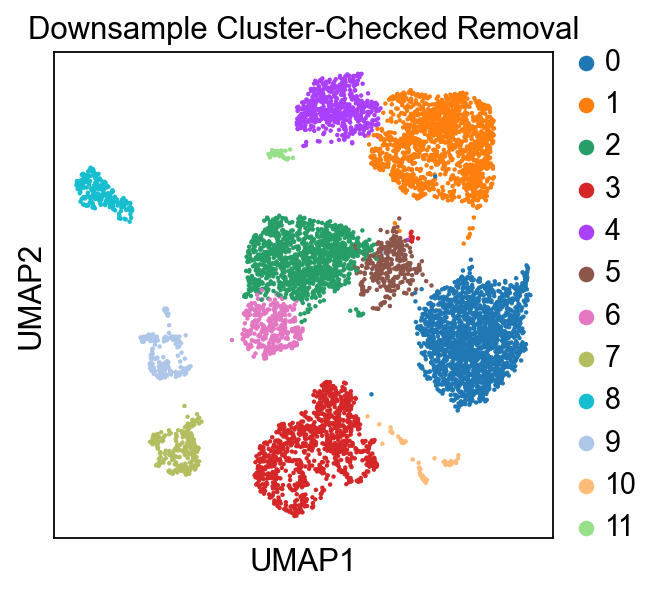

c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


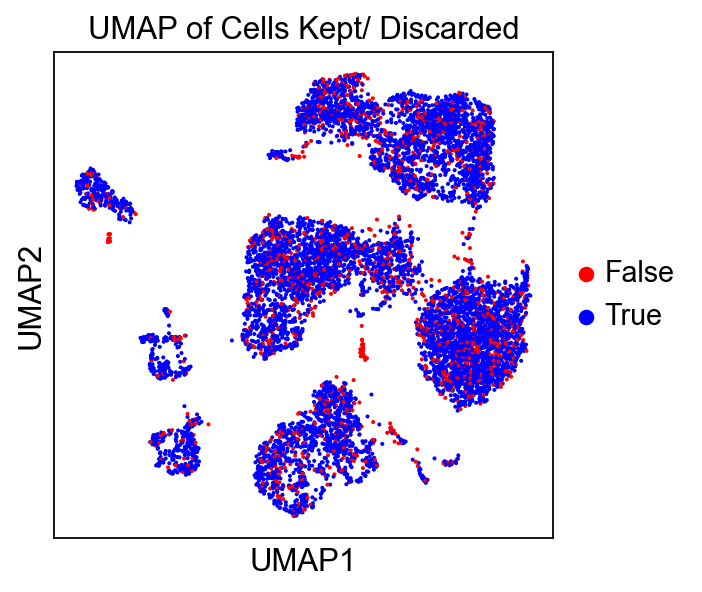

In [8]:
adata1 = sc.pp.subsample(copydata, fraction=.85, random_state=1, copy=True)
adata2 = sc.pp.subsample(copydata, fraction=.85, random_state=200, copy=True)
adata3 = sc.pp.subsample(copydata, fraction=.85, random_state=373, copy=True)

sc.pp.neighbors(adata1, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata1)
sc.tl.leiden(adata1, resolution= res, key_added = "leiden")
sc.pl.umap(adata1, color = ['leiden'], hspace = 1, title = "Downsample 1")
plt.show()

sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata2)
sc.tl.leiden(adata2, resolution= res, key_added = "leiden")
sc.pl.umap(adata2, color = ['leiden'], hspace = 1, title="Downsample 2")
plt.show()

sc.pp.neighbors(adata3, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata3)
sc.tl.leiden(adata3, resolution= res, key_added = "leiden")
sc.pl.umap(adata3, color = ['leiden'], hspace = 1, title="Downsample 3")
plt.show()
labels1 = adata1.obs['leiden']
labels2 = adata2.obs['leiden']
cmtx = pd.crosstab(labels2, labels1)
ncmtx = cmtx.div(cmtx.sum(axis=1), axis=0)
count_greater_than_08 = (ncmtx >= 0.8).sum().sum()
max_rows_columns = (ncmtx.shape[0])

plt.subplots(figsize=(20,15))
ax = sns.heatmap(ncmtx, annot=True)
ax.set(xlabel = 'random1', ylabel = 'random2', title = (f"1 vs 2 Normalized: Number of clusters with >=80% cell congruency: {count_greater_than_08} / {max_rows_columns}"))
plt.show()
# plt.subplots(figsize=(20,15))
# ax = sns.heatmap(cmtx, annot=True)
# ax.set(xlabel = 'random1', ylabel = 'random2', title = "1 vs 2 Raw")
# plt.show()

labels1 = adata1.obs['leiden']
labels2 = adata3.obs['leiden']
cmtx = pd.crosstab(labels2, labels1)
ncmtx = cmtx.div(cmtx.sum(axis=1), axis=0)
count_greater_than_08 = (ncmtx >= 0.8).sum().sum()
max_rows_columns = (ncmtx.shape[0])
plt.subplots(figsize=(20,15))
ax = sns.heatmap(ncmtx, annot=True)
ax.set(xlabel = 'random1', ylabel = 'random3', title = (f"1 vs 3 Normalized: Number of clusters with >=80% cell congruency: {count_greater_than_08} / {max_rows_columns}"))
plt.show()
# plt.subplots(figsize=(20,15))
# ax = sns.heatmap(cmtx, annot=True)
# ax.set(xlabel = 'random1', ylabel = 'random3', title = "1 vs 3 Raw")
# plt.show()

labels1 = adata2.obs['leiden']
labels2 = adata3.obs['leiden']
cmtx = pd.crosstab(labels2, labels1)
ncmtx = cmtx.div(cmtx.sum(axis=1), axis=0)
count_greater_than_08 = (ncmtx >= 0.8).sum().sum()
max_rows_columns = (ncmtx.shape[0])
plt.subplots(figsize=(20,15))
ax = sns.heatmap(ncmtx, annot=True)
ax.set(xlabel = 'random2', ylabel = 'random3', title = (f"2 vs 3 Normalized: Number of clusters with >=80% cell congruency: {count_greater_than_08} / {max_rows_columns}"))
plt.show()
# plt.subplots(figsize=(20,15))
# ax = sns.heatmap(cmtx, annot=True)
# ax.set(xlabel = 'random2', ylabel = 'random3', title = "2 vs 3 Raw")
# plt.show()


labels1 = adata_filtered.obs['leiden']
labels2 = adata1.obs['leiden']
cmtx = pd.crosstab(labels2, labels1)
ncmtx1 = cmtx.div(cmtx.sum(axis=1), axis=0)
count_greater_than_08 = (ncmtx1 >= 0.8).sum().sum()
max_rows_columns = (ncmtx1.shape[0])
plt.subplots(figsize=(20,15))
ax = sns.heatmap(ncmtx1, annot=True)
ax.set(xlabel = 'Full', ylabel = 'random1', title = (f"1 vs Full Normalized: Number of clusters with >=80% cell congruency: {count_greater_than_08} / {max_rows_columns}"))
plt.show()
# plt.subplots(figsize=(20,15))
# ax = sns.heatmap(cmtx, annot=True)
# ax.set(xlabel = 'Full', ylabel = 'random1', title = "1 vs Full Raw")
# plt.show()

labels1 = adata_filtered.obs['leiden']
labels2 = adata2.obs['leiden']
cmtx = pd.crosstab(labels2, labels1)
ncmtx2 = cmtx.div(cmtx.sum(axis=1), axis=0)
count_greater_than_08 = (ncmtx2 >= 0.8).sum().sum()
max_rows_columns = (ncmtx2.shape[0])
plt.subplots(figsize=(20,15))
ax = sns.heatmap(ncmtx2, annot=True)
ax.set(xlabel = 'Full', ylabel = 'random2', title = (f"2 vs Full Normalized: Number of clusters with >=80% cell congruency: {count_greater_than_08} / {max_rows_columns}"))
plt.show()
# plt.subplots(figsize=(20,15))
# ax = sns.heatmap(cmtx, annot=True)
# ax.set(xlabel = 'Full', ylabel = 'random2', title = "2 vs Full Raw")
# plt.show()

labels1 = adata_filtered.obs['leiden']
labels2 = adata3.obs['leiden']
cmtx = pd.crosstab(labels2, labels1)
ncmtx3 = cmtx.div(cmtx.sum(axis=1), axis=0)
count_greater_than_08 = (ncmtx3 >= 0.8).sum().sum()
max_rows_columns = (ncmtx3.shape[0])
#max_rows_columns = max(ncmtx3.shape[0], ncmtx3.shape[1])
plt.subplots(figsize=(20,15))
ax = sns.heatmap(ncmtx3, annot=True)
ax.set(xlabel = 'Full', ylabel = 'random3', title = (f"3 vs Full Normalized: Number of clusters with >=80% cell congruency: {count_greater_than_08} / {max_rows_columns}"))
plt.show()
# plt.subplots(figsize=(20,15))
# ax = sns.heatmap(cmtx, annot=True)
# ax.set(xlabel = 'Full', ylabel = 'random3', title = "3 vs Full Raw")
# plt.show()


x = 0
ncmtx_list = [ncmtx1, ncmtx2, ncmtx3]
data_frames_dict = {}
while x <= 2:
    # Define the threshold for keeping cells
    threshold = 0.8
    ncmtx = ncmtx_list[x]

    # Identify clusters with scores greater than or equal to 0.8
    clusters_above_threshold = ncmtx.columns[ncmtx.max(axis=0) >= threshold]

    # Create a DataFrame to store selected clusters and row values
    selected_clusters_df = pd.DataFrame(index=ncmtx.index, columns=['Row'] + clusters_above_threshold.tolist())

    # Fill the 'Row' column with row values
    selected_clusters_df['Row'] = selected_clusters_df.index

    # Fill the DataFrame with column labels for rows with scores above the threshold
    for cluster in clusters_above_threshold:
        selected_clusters_df[cluster] = ncmtx[cluster].apply(lambda x: cluster if x >= threshold else None)

    # Melt the DataFrame to have rows first, then columns
    selected_clusters_df = selected_clusters_df.melt(id_vars=['Row'], value_vars=clusters_above_threshold, var_name='Cluster')

    # Drop rows with NaN values
    selected_clusters_df = selected_clusters_df.dropna()

    # Reset index for the final result
    selected_clusters_df.reset_index(drop=True, inplace=True)
    selected_clusters_df = selected_clusters_df[['Row', 'Cluster']]

    rows_below_threshold = ncmtx.index.difference(selected_clusters_df['Row'])

    # Iterate over rows below the threshold and find additional clusters
    for row in rows_below_threshold:
        # Sort clusters by score in descending order
        sorted_clusters = ncmtx.loc[row].sort_values(ascending=False)
        
        # Find the minimum number of clusters to reach a combined score of at least 0.8
        cumulative_sum = 0
        min_clusters = []
        
        for cluster, score in sorted_clusters.items():
            cumulative_sum += score
            min_clusters.append(cluster)
            
            if cumulative_sum >= threshold:
                break

        # Append the row value and selected clusters to the existing DataFrame
        additional_clusters_df = pd.DataFrame({'Row': [row], 'Cluster': [min_clusters]})
        selected_clusters_df = pd.concat([selected_clusters_df, additional_clusters_df], ignore_index=True)

    selected_clusters_df = selected_clusters_df.sort_values(by='Row').reset_index(drop=True)
    data_frames_dict[f'iteration{x}'] =  selected_clusters_df
    x = x + 1
print("Selected Clusters and Column Values:")
print(data_frames_dict)


df_clusters1 = data_frames_dict['iteration0']
df_clusters2 = data_frames_dict['iteration1']
df_clusters3 = data_frames_dict['iteration2']

# Build mappings for each dataframe
cluster_mappings = []
for df_clusters in [df_clusters1, df_clusters2, df_clusters3]:
    mapping = {}
    for index, row in df_clusters.iterrows():
        allowed_clusters = row['Cluster']
        if not isinstance(allowed_clusters, list):
            allowed_clusters = [allowed_clusters]
        mapping[row['Row']] = allowed_clusters
    cluster_mappings.append(mapping)

# Get the cluster labels for each cell in dataset1 and dataset2
clusters_dataset1 = adata1.obs['leiden']  # Replace 'leiden' with your actual cluster column name if different
clusters_dataset2 = adata2.obs['leiden']  # Replace 'leiden' with your actual cluster column name if different
clusters_dataset3 = adata3.obs['leiden']
clusters_dataset0 = adata_filtered.obs['leiden']

reduced_clusters = {1: clusters_dataset1, 2: clusters_dataset2, 3: clusters_dataset3}
# Filter out cells from dataset2 based on the mappings
cells_to_keep = []
for cell in adata2.obs_names:
    correct_count = 0
    total_count = 0
    x = 1
    for mapping in cluster_mappings:
        if cell in reduced_clusters[x].index:
            total_count += 1
            cluster_label_dataset1 = reduced_clusters[x][cell]
            cluster_label_root = clusters_dataset0[cell]
            if cluster_label_root in mapping.get(cluster_label_dataset1, []):
                correct_count += 1
        x = x + 1
    # Keep the cell if it's correct in at least two dataframes or if it appears in less than two dataframes
    if correct_count >= 2 or (total_count < 2 & correct_count == 1):
        cells_to_keep.append(cell)

# Subset dataset2 to only include cells that are in the list of cells to keep
adata0_filtered = adata_filtered[cells_to_keep]

sc.pl.umap(adata0_filtered, color = ['leiden'], hspace = 1, title="Downsample Cluster-Checked Removal")

adata.obs['keep'] = adata.obs_names.isin(cells_to_keep)

# Convert the boolean array to a categorical type for better plotting
adata.obs['keep'] = adata.obs['keep'].astype('category')

# Plot the UMAP
sc.pl.umap(adata, color='keep', palette=['red', 'blue'], title='UMAP of Cells Kept/ Discarded')